In [2]:
import numpy as np
import pandas as pd
import csv
import re
import time

In [3]:
rawdata = pd.read_csv('raw_data/training_set_no_time.csv', encoding = "ISO-8859-1")

In [4]:
rawdata.head()

,Engagements,Followers at Posting,Type,Description
0,502093,36984682,Video,The @raptors bench trio of @sergeibaka @norman...
1,603380,36984682,Video,@kyle_lowry7 pulls from deep for the @raptors ...
2,603380,36984682,Video,@k_mid22 with some english on the @bucks dime!
3,725100,36984682,Video,Kawhi punches it home with the left on TNT!
4,661446,36984682,Video,@giannis_an34 goes baseline early to rock the ...


In [5]:
rawdata['len_text'] = list(map(lambda x: len(str(x)), rawdata['Description']))
rawdata['word_ct'] = list(map(lambda x: str(x).count(' '), rawdata['Description']))
rawdata['excl_ct'] = list(map(lambda x: str(x).count('!'), rawdata['Description']))
rawdata['emoji_ct'] = list(map(lambda x: str(x).count('??'), rawdata['Description']))
rawdata['ques_ct'] = list(map(lambda x: str(x).replace("??", "").count('?'), rawdata['Description']))
rawdata['period_ct'] = list(map(lambda x: str(x).count('.'), rawdata['Description']))
rawdata['comma_ct'] = list(map(lambda x: str(x).count(','), rawdata['Description']))
rawdata['caps_ct'] = list(map(lambda x: len(re.findall(r'[A-Z]', str(x))), rawdata['Description']))
rawdata['tags_ct'] = list(map(lambda x: str(x).count('@'), rawdata['Description']))

In [14]:
import re
def hasTag(y):
    if (y is not None):
        if len(y) > 0:
            if (y[0] == '@'):
                return True
    else:
        return False

In [15]:
##regex = ' \s+\n,.-_!?/\\><()&'
regex = "[\s\n\x91\x92,-/\\><()&!?\*^#|:;']+"
rawdata['player'] = list(map(lambda x: list(filter(lambda y: hasTag(y), re.split(regex, str(x)))), rawdata['Description']))

In [18]:
rawdata['player'].head()

0    [@raptors, @sergeibaka, @normanpowell4, @fredv...
1                             [@kyle_lowry7, @raptors]
2                                   [@k_mid22, @bucks]
3                                                   []
4                                      [@giannis_an34]
Name: player, dtype: object

In [19]:
teams = pd.read_csv('raw_data/teams.csv')
teams.head()

,Team Name,Insta_ID,Number of Posts,Number of Followers
0,Atlanta Hawks,atlhawks,7336,1M
1,Boston Celtics,celtics,7822,4.2M
2,Brooklyn Nets,brooklynnets,6363,1.2M
3,Charlotte Hornets,hornets,9653,1M
4,Chicago Bulls,chicagobulls,5202,4.4M


In [20]:
# function for pulling instagram followers:
import urllib.request, json 
def get_followers(searchquery):
    url = 'https://www.instagram.com/' + searchquery + '/?__a=1'
    with urllib.request.urlopen(url) as u:
        data = json.loads(u.read().decode())
        return data['graphql']['user']['edge_followed_by']['count']

In [21]:
# distinguish player from team:
def get_player_followers(searchquery):
    print(searchquery)
    time.sleep(2)
    if searchquery not in teams['Insta_ID']:
        followers = 0
        try:
            followers = get_followers(searchquery)
        except Exception:
            print("HAS ERROR")
        return followers
    return 0
# team:
def get_team_followers(searchquery):
    print(searchquery)
    time.sleep(2)
    if searchquery in teams['Insta_ID']:
        followers = 0
        try:
            followers = get_followers(searchquery)
        except Exception:
            print("HAS ERROR")
        return followers
    return 0

In [22]:
## Gather the follower count for all players:
player_list = []
rawdata['player'].values
for i in rawdata['player']:
    player_list = player_list + i
player_set = list(set(player_list))
print(len(player_set))
print(len(player_list))
## Gather count for all teams:
team_set = teams['Insta_ID']
print(len(team_set))

848
11714
30


In [23]:
# player fc
pfc = pd.DataFrame(player_set)
pfc.columns = ['player']
# team fc
tfc = pd.DataFrame(team_set)
tfc.columns = ['team']

In [24]:
### RUN FOLLOWING TO GET PLAYER TEAM FOLLOWER COUNT!
#pfc['fc'] = pfc['player'].apply(lambda x: get_player_followers(x.strip('@')))
#tfc['fc'] = tfc['team'].apply(lambda x: get_team_followers(x.strip('@')))


In [25]:
#pfc.to_csv('player_follower_count.csv')
#tfc.to_csv('team_follower_count.csv')

In [26]:
pfc = pd.read_csv('player_follower_count.csv', index_col=1)
tfc = pd.read_csv('team_follower_count.csv', index_col=1)
fc = pd.concat([pfc, tfc])
import operator
import functools
def follower_count_text():
    # 1 - (1-pA1)(1-pA2)...
    tmp_list = [[fc.loc[player, 'fc'] if player in fc.index else 0 for player in list_players] for list_players in rawdata['player']]
    tot_fc = []
    for list_players in tmp_list:
        total = sum(list_players)
        if total == 0:
            tot_fc.append(0)
            continue
        newVal = (1 - functools.reduce(operator.mul, [1-v/total for v in list_players], 1)) * total
        tot_fc.append(newVal)
    return(tot_fc)


In [27]:
fct = follower_count_text()

In [28]:
print(len(rawdata['player']))
rawdata.shape

7766


(7766, 14)

## Merge follower count w/ main data

In [ ]:
# def get_union(l):
#     ## to do
#     return 0
# def get_and_combine_followers(l):
#     follower_count = []
#     for item in l:
#         follower_count.append(get_player_followers(item))
#     # pick custom combine function
#     return get_union(follower_count)

In [29]:
rawdata.head()
#rawdata['player_follower_count'] = list(map(lambda x: get_and_combine(x), rawdata['player']))
rawdata['follower_count'] = fct

In [30]:
rawdata.columns.values

array(['Engagements', 'Followers at Posting', 'Type', 'Description',
       'len_text', 'word_ct', 'excl_ct', 'emoji_ct', 'ques_ct',
       'period_ct', 'comma_ct', 'caps_ct', 'tags_ct', 'player',
       'follower_count'], dtype=object)

## Merge time data

In [31]:
timedata = pd.read_csv('raw_data/time_data.csv', encoding = "ISO-8859-1")

In [33]:
rawdata['Play Type'] = timedata['Play Type']
rawdata['Day of the Week'] = timedata['Day of the Week']
rawdata['Month'] = timedata['Month']
rawdata['Day'] = timedata['Day']
rawdata['Hour'] = timedata['Hour']
rawdata['Minute'] = timedata['Minute']
rawdata['Second'] = timedata['Second']

## Train RF and assess w/ CV

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from math import sqrt
import matplotlib.pyplot as plt

In [64]:
response = 'Engagements'

## TODO: can change predictors depending on correlation plot
predictors = ['Followers at Posting', 'Type', 
              #'len_text', 
              'word_ct', 'excl_ct', 'emoji_ct', 
              'ques_ct', 'period_ct', 'comma_ct', 'caps_ct', 'tags_ct', 
              'follower_count',
              #'Play Type',
             'Day of the Week', 'Month', 'Day', 'Hour',
             #'Minute'#, 'Second'
             ]
#predictors = 'follower_count'
## TODO: replace following rawdata with merged data
y_data = rawdata[response]
log_y_data = np.log(y_data)
X_data = rawdata[predictors]
## encode data for RF
X_encoded = pd.get_dummies(X_data)
sc_users = StandardScaler()
X_encoded_transformed = sc_users.fit_transform(X_encoded)

In [36]:
def get_mae(X, y, model):
    # multiple by -1 to make positive MAE score instead of neg value returned as sklearn convention
    score = -1 * cross_val_score(model, 
                                X, y, 
                                cv = 5,
                                scoring = 'neg_mean_absolute_error')
    return score

In [93]:
np.sort(y_data)

array([ 127816,  143702,  154556, ..., 1075434, 1077014, 1129585], dtype=int64)

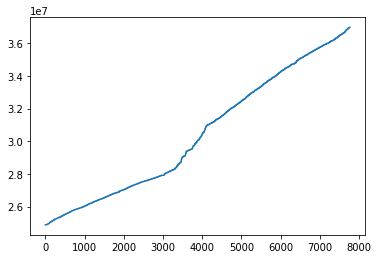

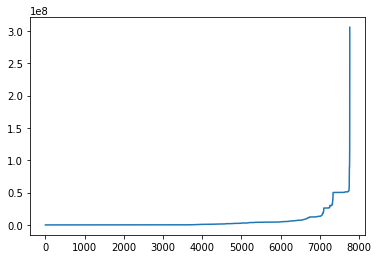

In [186]:
plt.plot(np.sort(X_data['Followers at Posting']))
plt.show()
plt.plot(np.sort(X_data['follower_count']))
plt.show()

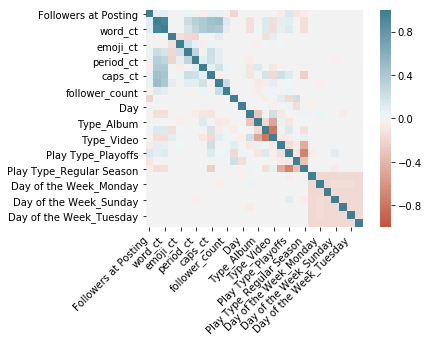

In [164]:
import seaborn as sns
corr = X_encoded.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.show()

In [127]:
from sklearn.linear_model import LinearRegression

baseline_predictors = ['Followers at Posting', 'len_text', 'word_ct', 'excl_ct', 'emoji_ct', 
              'ques_ct', 'period_ct', 'comma_ct', 'caps_ct', 'tags_ct']
baseline_model = LinearRegression()
baseline_scores = get_mae(rawdata[baseline_predictors], y_data, baseline_model)
print('Baseline MAE: ' + str(baseline_scores.mean() / y_data.mean()))
print('No model MAE: ' + str(np.mean(abs(y_data.mean() - y_data) / y_data.mean())))



Baseline MAE: 0.23859261964
No model MAE: 0.2551132793792224


In [91]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor

#model = RandomForestRegressor(50)
#model = KNeighborsClassifier()
#model = LinearRegression()
model = GradientBoostingRegressor(learning_rate = 0.14)
scores = get_mae(X_encoded, y_data, model)

print('MAE: ' + str(scores.mean() / y_data.mean()))


MAE: 0.05766016958881488


## Train and assess keras NN (https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/)

In [49]:
import matplotlib.pyplot as plt
plt.scatter(rawdata['word_ct'], rawdata['len_text'])
plt.show()

<Figure size 640x480 with 1 Axes>

In [24]:
teams.head()

,Team Name,Insta_ID,Number of Posts,Number of Followers
0,Atlanta Hawks,atlhawks,7336,1M
1,Boston Celtics,celtics,7822,4.2M
2,Brooklyn Nets,brooklynnets,6363,1.2M
3,Charlotte Hornets,hornets,9653,1M
4,Chicago Bulls,chicagobulls,5202,4.4M


In [21]:
from lxml import html
import requests
from lxml.html import fromstring, tostring


In [42]:
searchquery = 'stephencurry30'
url = 'https://www.instagram.com/' + searchquery + '/?__a=1'
page = requests.get(url)
tree = html.fromstring(page.content)


In [50]:
import urllib.request, json 
with urllib.request.urlopen(url) as u:
    data = json.loads(u.read().decode())
    print(data)

{'logging_page_id': 'profilePage_324599988', 'show_suggested_profiles': True, 'graphql': {'user': {'biography': '@vsonwatch', 'blocked_by_viewer': False, 'country_block': False, 'external_url': 'http://fb.me/StephenvsTheGame', 'external_url_linkshimmed': 'https://l.instagram.com/?u=http%3A%2F%2Ffb.me%2FStephenvsTheGame&e=ATO5G_MDgJUOJZ43Bq_Bb4jIO0lAw12fKgakgMOZlFULA1TTeH3FHag-vrLck7bIEgdMLV-I', 'edge_followed_by': {'count': 25661091}, 'followed_by_viewer': False, 'edge_follow': {'count': 648}, 'follows_viewer': False, 'full_name': 'Wardell Curry', 'has_channel': False, 'has_blocked_viewer': False, 'highlight_reel_count': 4, 'has_requested_viewer': False, 'id': '324599988', 'is_business_account': False, 'is_joined_recently': False, 'business_category_name': None, 'is_private': False, 'is_verified': True, 'edge_mutual_followed_by': {'count': 0, 'edges': []}, 'profile_pic_url': 'https://scontent-sea1-1.cdninstagram.com/vp/eac4ca641e352ef94e652fb39583f44a/5D859F9A/t51.2885-19/s150x150/2227

In [52]:
data['logging_page_id']

'profilePage_324599988'

In [53]:
data['graphql']

{'user': {'biography': '@vsonwatch',
  'blocked_by_viewer': False,
  'country_block': False,
  'external_url': 'http://fb.me/StephenvsTheGame',
  'external_url_linkshimmed': 'https://l.instagram.com/?u=http%3A%2F%2Ffb.me%2FStephenvsTheGame&e=ATO5G_MDgJUOJZ43Bq_Bb4jIO0lAw12fKgakgMOZlFULA1TTeH3FHag-vrLck7bIEgdMLV-I',
  'edge_followed_by': {'count': 25661091},
  'followed_by_viewer': False,
  'edge_follow': {'count': 648},
  'follows_viewer': False,
  'full_name': 'Wardell Curry',
  'has_channel': False,
  'has_blocked_viewer': False,
  'highlight_reel_count': 4,
  'has_requested_viewer': False,
  'id': '324599988',
  'is_business_account': False,
  'is_joined_recently': False,
  'business_category_name': None,
  'is_private': False,
  'is_verified': True,
  'edge_mutual_followed_by': {'count': 0, 'edges': []},
  'profile_pic_url': 'https://scontent-sea1-1.cdninstagram.com/vp/eac4ca641e352ef94e652fb39583f44a/5D859F9A/t51.2885-19/s150x150/22277378_1720913538216240_2580026733478543360_n.jpg

In [54]:
data['graphql']['user']['edge_followed_by']['count']

25661091

In [52]:
rawdata.head()

,Engagements,Followers at Posting,Type,Description,len_text,word_ct,excl_ct,ques_ct,period_ct,comma_ct,caps_ct,tags_ct,player
0,502093,36984682,Video,The @raptors bench trio of @sergeibaka @norman...,95,14,1,0,0,0,2,4,"[@raptors, @sergeibaka, @normanpowell4, @fredv..."
1,603380,36984682,Video,@kyle_lowry7 pulls from deep for the @raptors ...,64,11,1,0,0,0,3,2,"[@kyle_lowry7, @raptors]"
2,603380,36984682,Video,@k_mid22 with some english on the @bucks dime!,46,7,1,0,0,0,0,2,"[@k_mid22, @bucks]"
3,725100,36984682,Video,Kawhi punches it home with the left on TNT!,43,8,1,0,0,0,4,0,[]
4,661446,36984682,Video,@giannis_an34 goes baseline early to rock the ...,57,9,1,0,0,0,3,1,[@giannis_an34]


## Load and clean test data

In [37]:
#testdata = pd.read_csv('raw_data/test_set.csv', encoding = "ISO-8859-1")
testdata = pd.read_csv('holdout_set_with_data.csv', encoding = "ISO-8859-1")

In [39]:
testdata.head()

,Engagements,Followers at Posting,Created,Type,Day of the Week,Month,Day,Hour,Minute,Second,Type.1,Description
0,NaN,36984682,2019-05-22 00:31:55 EDT,Playoffs,Wednesday,5,22,0,31,55,Photo,The @raptors even up the Eastern Conference Fi...
1,NaN,36984682,2019-05-21 23:20:41 EDT,Playoffs,Tuesday,5,21,23,20,41,Photo,The @raptors even the Eastern Conference Final...
2,NaN,36984682,2019-05-21 21:18:51 EDT,Playoffs,Tuesday,5,21,21,18,51,Video,@sergeibaka keeps it alive for the @raptors! (...
3,NaN,36955156,2019-05-21 18:20:09 EDT,Playoffs,Tuesday,5,21,18,20,9,Video,???? The SUPERHUMAN HANDS of Giannis & Kawhi ?...
4,NaN,36955156,2019-05-21 15:04:31 EDT,Playoffs,Tuesday,5,21,15,4,31,Video,?? the @raptors & @bucks in transition! #NBABr...


In [44]:
testdata['len_text'] = list(map(lambda x: len(str(x)), testdata['Description']))
testdata['word_ct'] = list(map(lambda x: str(x).count(' '), testdata['Description']))
testdata['excl_ct'] = list(map(lambda x: str(x).count('!'), testdata['Description']))
testdata['emoji_ct'] = list(map(lambda x: str(x).count('??'), testdata['Description']))
testdata['ques_ct'] = list(map(lambda x: str(x).replace("??", "").count('?'), testdata['Description']))
testdata['period_ct'] = list(map(lambda x: str(x).count('.'), testdata['Description']))
testdata['comma_ct'] = list(map(lambda x: str(x).count(','), testdata['Description']))
testdata['caps_ct'] = list(map(lambda x: len(re.findall(r'[A-Z]', str(x))), testdata['Description']))
testdata['tags_ct'] = list(map(lambda x: str(x).count('@'), testdata['Description']))
testdata['player'] = list(map(lambda x: list(filter(lambda y: hasTag(y), re.split(regex, str(x)))), testdata['Description']))

In [46]:

test_player_list = []
testdata['player'].values
for i in testdata['player']:
    test_player_list = test_player_list + i
test_player_set = list(set(test_player_list))
print(len(test_player_set))
print(len(test_player_list))
# player fc
test_pfc = pd.DataFrame(test_player_set)
test_pfc.columns = ['player']
test_pfc['fc'] = test_pfc['player'].apply(lambda x: get_player_followers(x.strip('@')))

319
1489
nuggets
_tonyparker09
therea1djones
gallo_locknez
statefarm
sviat_10
dsabonis11
spidadmitchell
atlhawks
chrisbosh
trezz24
Warriors
milesbridges
djstephens30
jcollins20_
josh_j11
iisuperwomanii
jrich_0
thenbpa
dallaswings
kuzmakyle
nbagleague
imanshumpert
DetroitPistons
lakers
pelicansnba
kuz
ivicazubac
willthethrillb5
reggie_jackson
paulmillsap4
rademita
dloading
washmystics
rudygay
sterlingbrown23
ahmad_monk
frank_ntilikina
kevinlove
adamsilvernba
swayyvo
RajonRondo
pacers
joelembiid
govballnyc
impjrose
detroitpistons
fs1
lvaces
indianageorge3
k_mid22
UtahJazz
teamswish
vicoladipo
deandreayton
nbahistory
trailblazers
laurimarkkanen
nba
javalemcgee
washwizards
iamjustise
tobiasharris
cp3
espn
jumpman23
jeremylamb1
NBAonTNT
LongIslandNets
nyknicks
kkorv26
Giannis_An34
sbird10
sacramentokings
Celtics
JHarden13
jeramigrant
ebled2
money23green
unclejeffgreen
jabari_bird
usabasketball
boban
antdavis23
fchwpo
repyourwork
boogiecousins
barenakedladiesmusic
Cavs
chicagobulls
bradbeal3

In [47]:
test_pfc.to_csv('test_pfc.csv')
test_pfc = pd.read_csv('test_pfc.csv', index_col=1)
test_fc = pd.concat([test_pfc, tfc])
import operator
import functools
def test_follower_count_text():
    # 1 - (1-pA1)(1-pA2)...
    tmp_list = [[fc.loc[player, 'fc'] if player in fc.index else 0 for player in list_players] for list_players in testdata['player']]
    tot_fc = []
    for list_players in tmp_list:
        total = sum(list_players)
        if total == 0:
            tot_fc.append(0)
            continue
        newVal = (1 - functools.reduce(operator.mul, [1-v/total for v in list_players], 1)) * total
        tot_fc.append(newVal)
    return(tot_fc)


In [49]:
testdata['follower_count'] = test_follower_count_text()

In [66]:
X_test_data = testdata[predictors]
## encode data for RF
X_test_encoded = pd.get_dummies(X_test_data)
X_test_encoded_transformed = sc_users.fit_transform(X_test_encoded)

In [53]:
## TODO: fit model on all of training, and predict here
##from sklearn.ensemble import RandomForestRegressor
#model = RandomForestRegressor(50)
model = GradientBoostingRegressor(learning_rate = 0.14)
model.fit(X_encoded_transformed, y_data)
#model.predict

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [54]:
model.predict(X_)

ValueError: Number of features of the model must match the input. Model n_features is 23 and input n_features is 24 

In [60]:
X_encoded.columns

Index(['Followers at Posting', 'word_ct', 'excl_ct', 'emoji_ct', 'ques_ct',
       'period_ct', 'comma_ct', 'caps_ct', 'tags_ct', 'follower_count',
       'Month', 'Day', 'Hour', 'Type_Album', 'Type_Photo', 'Type_Video',
       'Day of the Week_Friday', 'Day of the Week_Monday',
       'Day of the Week_Saturday', 'Day of the Week_Sunday',
       'Day of the Week_Thursday', 'Day of the Week_Tuesday',
       'Day of the Week_Wednesday'],
      dtype='object')

In [67]:
X_test_encoded.columns

Index(['Followers at Posting', 'word_ct', 'excl_ct', 'emoji_ct', 'ques_ct',
       'period_ct', 'comma_ct', 'caps_ct', 'tags_ct', 'follower_count',
       'Month', 'Day', 'Hour', 'Type_Off Season', 'Type_Playoffs',
       'Type_Pre-Season', 'Type_Regular Season', 'Day of the Week_Friday',
       'Day of the Week_Monday', 'Day of the Week_Saturday',
       'Day of the Week_Sunday', 'Day of the Week_Thursday',
       'Day of the Week_Tuesday', 'Day of the Week_Wednesday'],
      dtype='object')

In [71]:
rawdata

,Engagements,Followers at Posting,Type,Description,len_text,word_ct,excl_ct,emoji_ct,ques_ct,period_ct,...,tags_ct,player,follower_count,Play Type,Day of the Week,Month,Day,Hour,Minute,Second
0,502093,36984682,Video,The @raptors bench trio of @sergeibaka @norman...,95,14,1,0,0,0,...,4,"[@raptors, @sergeibaka, @normanpowell4, @fredv...",2.903728e+06,Playoffs,Tuesday,5,21,23,30,51
1,603380,36984682,Video,@kyle_lowry7 pulls from deep for the @raptors ...,64,11,1,0,0,0,...,2,"[@kyle_lowry7, @raptors]",2.882463e+06,Playoffs,Tuesday,5,21,22,53,33
2,603380,36984682,Video,@k_mid22 with some english on the @bucks dime!,46,7,1,0,0,0,...,2,"[@k_mid22, @bucks]",1.722830e+05,Playoffs,Tuesday,5,21,22,19,58
3,725100,36984682,Video,Kawhi punches it home with the left on TNT!,43,8,1,0,0,0,...,0,[],0.000000e+00,Playoffs,Tuesday,5,21,22,2,41
4,661446,36984682,Video,@giannis_an34 goes baseline early to rock the ...,57,9,1,0,0,0,...,1,[@giannis_an34],0.000000e+00,Playoffs,Tuesday,5,21,20,47,49
5,322444,36955156,Photo,Congrats to the 2018-19 NBA All-Rookie First T...,104,14,1,0,0,0,...,2,"[@lukadoncic, @traeyoung]",1.505817e+06,Playoffs,Tuesday,5,21,14,2,32
6,722540,36955156,Video,The @warriors locked in for four games to adva...,106,16,1,0,0,0,...,1,[@warriors],1.235188e+07,Playoffs,Tuesday,5,21,12,30,53
7,339265,36955156,Photo,Will the @bucks take a commanding 3-1 lead... ...,88,16,0,1,0,3,...,2,"[@bucks, @raptors]",2.882463e+06,Playoffs,Tuesday,5,21,8,59,2
8,443330,36955156,Photo,TAP to SHOP the @warriors Western Conference C...,75,10,1,0,0,0,...,2,"[@warriors, @nbastore]",1.235188e+07,Playoffs,Tuesday,5,21,0,48,16
9,652193,36955156,Video,Hey @stephencurry30... that was the first time...,121,16,1,0,0,3,...,2,"[@stephencurry30, @nbahistory]",2.605054e+07,Playoffs,Tuesday,5,21,0,38,18
